## Stable Diffusion XL1.0 fine tune with Lora in DreamBooth method
* This is an experiment for fine tune SD-XL-v1.0 with Kohya-ss unpublic sd-scripts.
* Character(Person) training example.
* Tested with ml.g5.2xlarge SageMaker notebook.
* Scripts and codes use [kohya-ss/sd-scripts](https://github.com/kohya-ss/sd-scripts).
* Training images come from [here](https://github.com/shirayu/example_lora_training).
* Lora training is basing on the method of DreamBooth+Caption(without using class_images to aviod over-fitting). 
* Besides the way of DreamBooth+Caption, Lora can also use other methods, such as DreamBooth+identifier+class and classic text2image fine tuning. Detailed info you can refer to https://github.com/darkstorm2150/sd-scripts/blob/main/docs/train_README-en.md
* If you can read Chinese and feel hard to dig into kohya-ss repo(Japanese content for now ...), you can map the content from [Akegarasu repo](https://github.com/Akegarasu/lora-scripts) to kohya-ss for better understanding


## 1. Install dependencies

In [ ]:
!git clone -b sdxl https://github.com/kohya-ss/sd-scripts
%cd sd-scripts/
!sed -i 's/diffusers\[torch\]==0\.18\.2/diffusers[torch]==0.19.3/g; s/tensorboard==2\.10\.1/tensorboard==2.11.0/g' requirements.txt
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 --index-url https://download.pytorch.org/whl/cu118
!pip install -U -r requirements.txt
!pip install xformers==0.0.20 tensorboard==2.11.0 wandb prodigyopt

In [2]:
# fix some warnings and bugs poping up from notebook

!sudo rm -rf /lib64/libstdc++.so.6 /lib64/libstdc++.so.6
!sudo ln -s /home/ec2-user/anaconda3/envs/python3/lib/libstdc++.so.6 /lib64/libstdc++.so.6

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

## 2. Initialize training environment 

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

Refer "dataset-example.toml" to configure your own .toml file

In [ ]:
%%writefile dataset.toml
[general]
enable_bucket = true
shuffle_caption = true
caption_extension = '.txt'
keep_tokens = 0

# DreamBooth caption based character datasets
[[datasets]]
resolution = 1024
# min_bucket_reso = 640
# max_bucket_reso = 1536
# bucket_reso_steps = 32
batch_size = 2

  [[datasets.subsets]]
  image_dir = './images/sample'
  num_repeats = 10

In [ ]:
%%writefile sample_prompts.txt
# prompt 1
wta, 1girl, looking_at_viewer, blue_hair, short_twintails, hair_ornament, blue_eyes, blush, smile, open_mouth, shirt, skirt, kneehighs, brown_footwear, standing, solo --n lowres, worst quality, ugly, extra limbs, deformed legs, disfigured legs, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2) --w 1024 --h 1024 --d 3129467234 --l 7.5 --s 20

# # prompt 2
wta, 1girl, looking_at_viewer, blue_hair, short_twintails, hair_ornament, blue_eyes, blush, smile, open_mouth, shirt, skirt, kneehighs, brown_footwear, standing, solo --n lowres, worst quality, ugly, extra limbs, deformed legs, disfigured legs, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2) --w 1024 --h 1024 --d 3129467235 --l 7.5 --s 20

In [6]:
MODEL_NAME = "stabilityai/stable-diffusion-xl-base-1.0"
DATASET_CONFIG = "./dataset.toml"
TRAIN_DATA_DIR = "./images/sample"
IMAGES_OUTPTS = "./images/outputs"
!mkdir -p $TRAIN_DATA_DIR $IMAGES_OUTPTS

In [ ]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/Wikipe-tan/* $TRAIN_DATA_DIR
!rm -rf dreambooth-stablediffusion-sagemaker-notebook

## 3. Train model

In [ ]:
!accelerate launch sdxl_train_network.py \
   --pretrained_model_name_or_path=$MODEL_NAME \
   --dataset_config=$DATASET_CONFIG \
   --output_dir="./output" \
   --network_module="networks.lora" \
   --max_train_epochs=10 \
   --network_train_unet_only \
   --learning_rate=1.0 \
   --lr_scheduler="cosine_with_restarts" \
   --lr_scheduler_num_cycles=1 \
   --network_dim=64 \
   --network_alpha=32 \
   --output_name="lora_wta" \
   --save_every_n_epochs=2 \
   --mixed_precision="fp16" \
   --gradient_checkpointing \
   --prior_loss_weight=1 \
   --max_token_length=225 \
   --save_model_as="safetensors" \
   --no_half_vae \
   --xformers \
   --optimizer_type="prodigy" \
   --sample_every_n_epochs=2 \
   --sample_prompts="./sample_prompts.txt" \
   --sample_sampler="euler_a" \
   --logging_dir="./logs" \
   --log_with="all" \
   --log_tracker_name="lora_wta" \
   --wandb_api_key="45983308f36536fe9bd4afd336edde8ce15730fe"

## 4. Mode inference testing

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

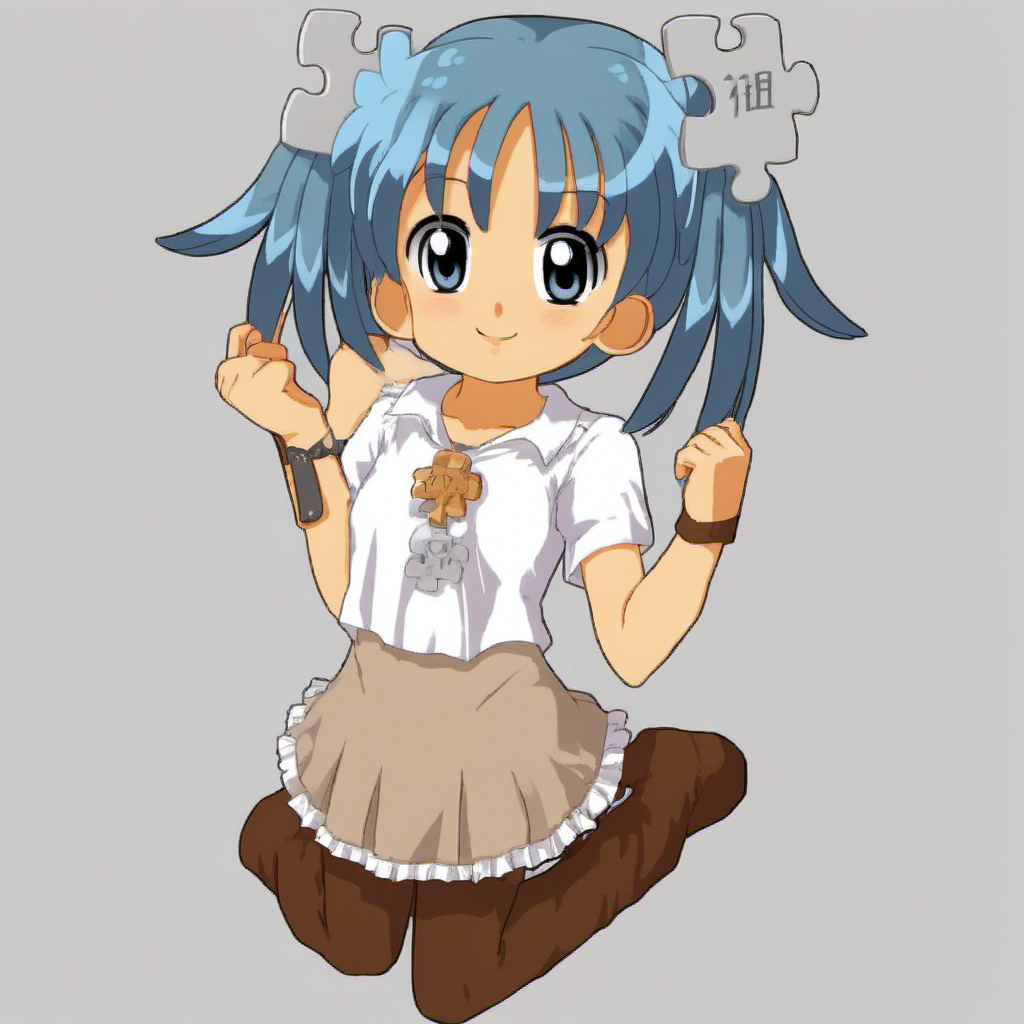

./images/outputs/5514132113067838_2023-08-01 10:41:12.png



  0%|          | 0/20 [00:00<?, ?it/s]

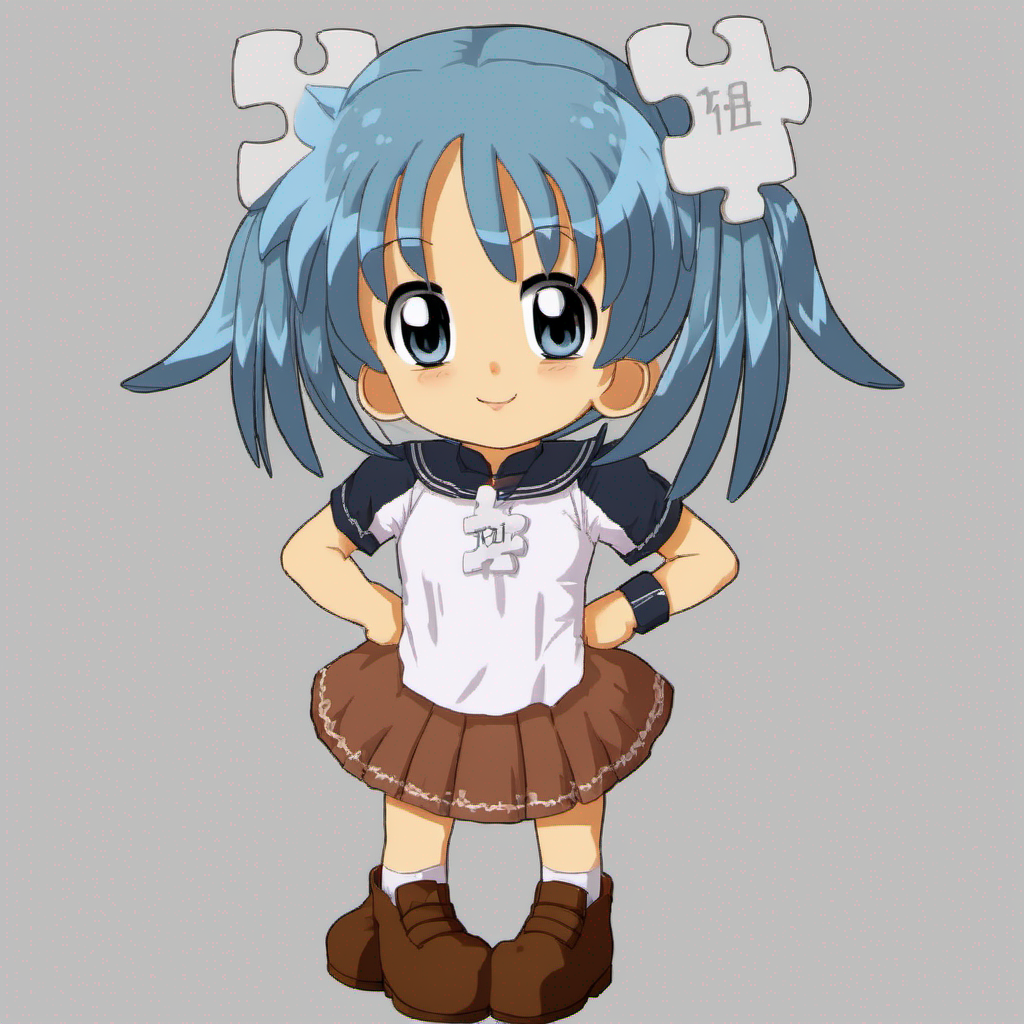

./images/outputs/5699731471595216_2023-08-01 10:41:22.png


Seeds for generating images: [5514132113067838, 5699731471595216]



In [14]:
import torch
import datetime

from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler

model_id_or_dir = r"stabilityai/stable-diffusion-xl-base-1.0"
lora_path = r"./output/lora_wta.safetensors"

scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id_or_dir, subfolder="scheduler")
generator = torch.Generator(device="cuda")
pipe = DiffusionPipeline.from_pretrained(model_id_or_dir, scheduler=scheduler, torch_dtype=torch.float16)

pipe.load_lora_weights(lora_path)
pipe.to(torch_dtype=torch.float16)
pipe.to("cuda")

# # Uncomment below codes, if you don't want to enable NFSW
# def dummy(images, **kwargs):
#     return images, False
# pipe.safety_checker = dummy

prompt = "wta, 1girl, looking_at_viewer, blue_hair, short_twintails, hair_ornament, blue_eyes, blush, smile, open_mouth, shirt, skirt, kneehighs, brown_footwear, standing, solo"
negative_prompt = "ugly, extra limbs, deformed legs, disfigured legs, (disfigured), mutated hands, misshapen hands, mutated fingers, fused fingers"

num_images = 2
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    image = pipe(
        prompt, 
        negative_prompt=negative_prompt,
        height=1024,
        width=1024,
        num_images_per_prompt=1,
        num_inference_steps=20,
        guidance_scale=7, 
        generator = generator
    ).images[0]
    display(image)
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)

# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")


  0%|          | 0/20 [00:00<?, ?it/s]

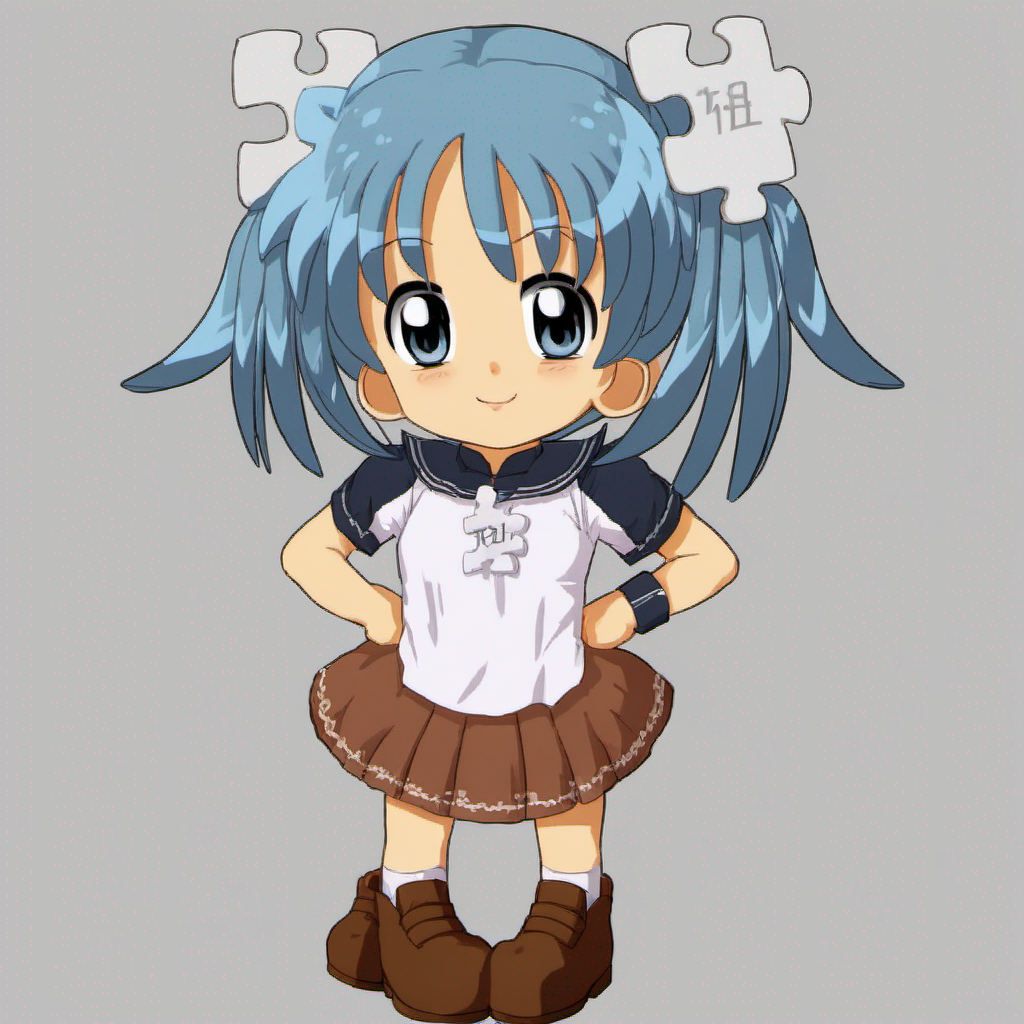

In [15]:
# Comment below codes, if you don't want to produce the same images again
seed = seeds[1] # use the first seed
generator.manual_seed(seed)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=1024,
    width=1024,
    num_images_per_prompt=1,
    num_inference_steps=20,
    guidance_scale=7,
    generator = generator
).images[0]
display(image)